<a href="https://colab.research.google.com/github/ncarolan/COS302/blob/main/HW5/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COS302 - HW5

In [1]:
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(precision=3, suppress=True)

## Problem 3

### (A)

In [2]:
! wget https://alf-s-room.com/etc/nandarou/binbows/binbows.jpg  # High-quality image ;)

--2025-08-18 18:30:49--  https://alf-s-room.com/etc/nandarou/binbows/binbows.jpg
Resolving alf-s-room.com (alf-s-room.com)... 163.44.185.225
Connecting to alf-s-room.com (alf-s-room.com)|163.44.185.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142558 (139K) [image/jpeg]
Saving to: ‘binbows.jpg’

binbows.jpg         100%[===================>] 139.22K  --.-KB/s    in 0.09s   

2025-08-18 18:30:50 (1.49 MB/s) - ‘binbows.jpg’ saved [142558/142558]



Image array of shape (480, 640, 3) with dtype: uint8


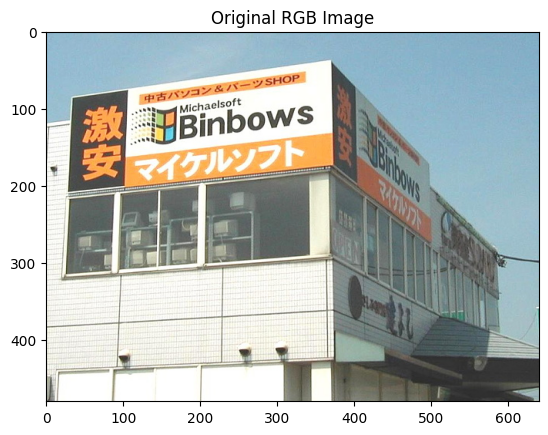

Reshaping image array to (480, 640)


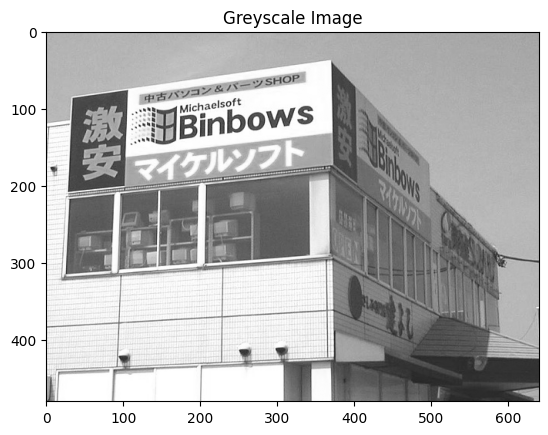

In [3]:
image_array = plt.imread('binbows.jpg')

print(f'Image array of shape {image_array.shape} with dtype: {image_array.dtype}')
plt.imshow(image_array)
plt.title('Original RGB Image')
plt.show()

image_array = np.mean(image_array, axis=2)

print(f'Reshaping image array to {image_array.shape}')
plt.imshow(image_array, cmap='grey')
plt.title('Greyscale Image')
plt.show()

### (B)

In [4]:
U, s_values, VT = np.linalg.svd(image_array)

print(f'U array of size {U.shape} with dtype {U.dtype}')
print(f'Singular Value array of size {s_values.shape} with dtype {s_values.dtype}')
print(f'V^T array of size {VT.shape} with dtype {VT.dtype}')

U array of size (480, 480) with dtype float64
Singular Value array of size (480,) with dtype float64
V^T array of size (640, 640) with dtype float64


In [5]:
# Transform s_values into a (480,640) array with singular values on the diagonal
S = np.zeros((480,640))
np.fill_diagonal(S, s_values)
print(f'Singular Value array of size {S.shape} with dtype {S.dtype}')

Singular Value array of size (480, 640) with dtype float64


Reconstructed image array shape: (480, 640)


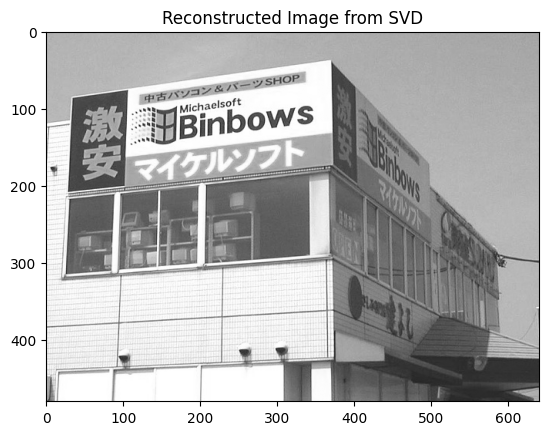

In [6]:
reconstructed_image = U @ S @ VT  # (480x480) x (480,640) x (640,640) -> (480,640)
print(f'Reconstructed image array shape: {reconstructed_image.shape}')

plt.title('Reconstructed Image from SVD')
plt.imshow(reconstructed_image, cmap='grey')
plt.show()

### (C)

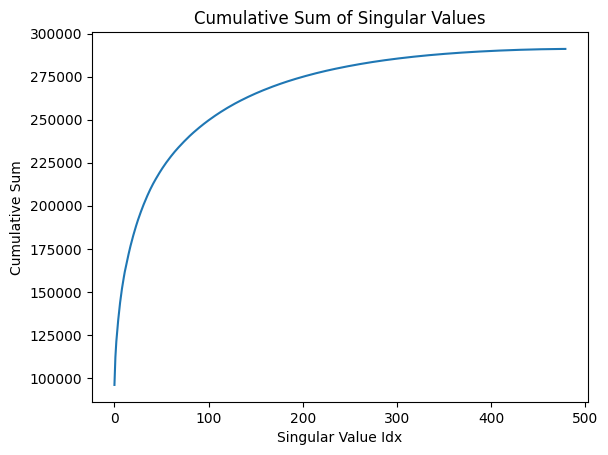

In [7]:
s_values_cumulative_sum = np.cumsum(s_values)

plt.plot(s_values_cumulative_sum)
plt.title('Cumulative Sum of Singular Values')
plt.ylabel('Cumulative Sum')
plt.xlabel('Singular Value Idx')
plt.show()

### (D)

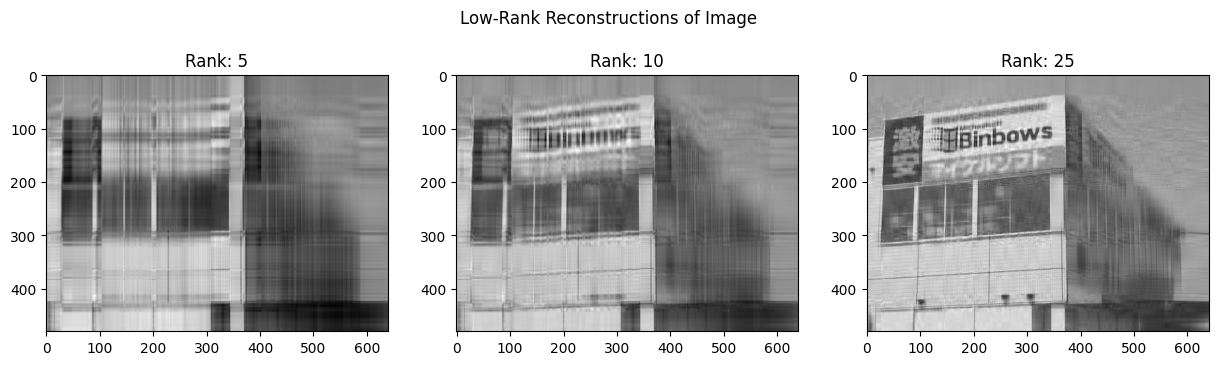

In [8]:
ranks = [5, 10, 25]
low_ranks = {}

fig, ax = plt.subplots(1, len(ranks), figsize=(len(ranks)*5, 4))
plt.suptitle(f'Low-Rank Reconstructions of Image')

for idx, rank in enumerate(ranks):
  S_low_rank = S.copy()
  S_low_rank[rank:, rank:] = 0

  low_rank_approx = U @ S_low_rank @ VT
  low_ranks[rank] = low_rank_approx

  ax[idx].imshow(low_rank_approx, cmap='grey')
  ax[idx].set_title(f'Rank: {rank}')

plt.show()

### (E)

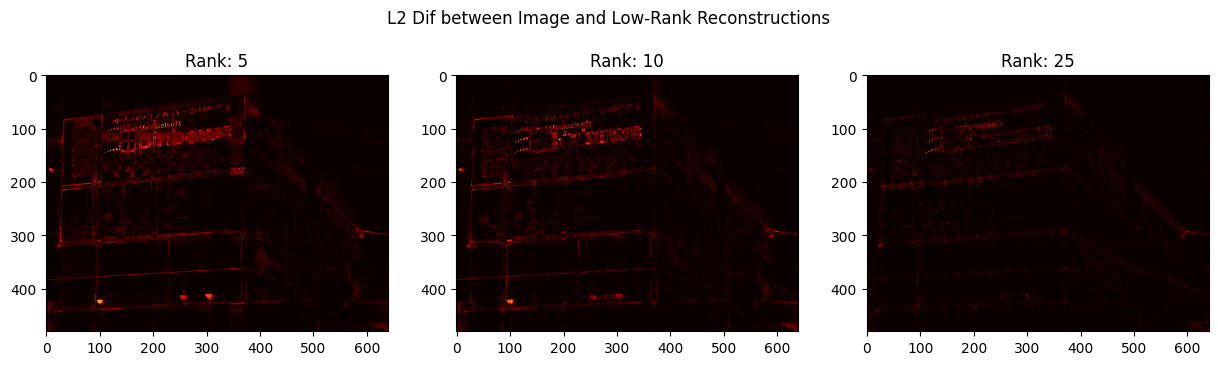

In [10]:
fig, ax = plt.subplots(1, len(ranks), figsize=(len(ranks)*5, 4))
plt.suptitle(f'L2 Dif between Image and Low-Rank Reconstructions')

for idx, rank in enumerate(ranks):
  low_rank_approx = low_ranks[rank]

  l2_dif = (image_array - low_rank_approx) ** 2

  ax[idx].imshow(l2_dif, cmap="hot")
  ax[idx].set_title(f'Rank: {rank}')

plt.show()

The approximations seem to lose the detailed visual structure in the image, particularly in edges, which is most obvious in the text/logos of this example. The amount of information loss is visibly much greater in the lower dimension reconstructions.

## Problem 4

### (A)

In [11]:
import pickle as pkl
import numpy as np
import gzip

filename = 'drive/My Drive/Colab Notebooks/COS302/nyt.pkl.gz'  # Remember to click "Mount Drive" first
with gzip.open(filename, 'rb') as fh:
  nyt = pkl.load(fh)

documents = nyt['docs']
vocab = nyt['vocab']

# Create reverse lookup table.
vocab_indices = dict([(w, i) for (i, w) in enumerate(vocab)])  # Ex: vocab_indices["company"] = 0
M = len(documents)
N = len(vocab)

print('%d documents, %d words' % (M, N))

tf = np.zeros((M, N))  # tf[m,n] = # of times word n appears in doc m / # of words in doc m
for doc_idx, doc in enumerate(documents):
  #words, word_counts = np.unique(doc, return_counts=True)
  total_words = sum(doc.values())
  for word, count in doc.items():
    tf[doc_idx, vocab_indices[word]] = count / total_words

8447 documents, 3012 words


### (B)

In [25]:
# idf = log(total # of docs / 1 + # of docs with word n)

idf = (tf != 0).astype('int') # Convert tf to 0/1 if a value is populated
idf = idf.sum(axis=0)  # Sum up along axis=0 -> (n,)
idf = np.log(M / (idf + 1))  # Compute idf from (# of docs with word n)

### (C)

In [27]:
# tf (M,N) @ idf (N,)
tf_idf = tf * idf
print(f'Creating TF-IDF matrix with shape: {tf_idf.shape}')

U, s_values, VT = np.linalg.svd(tf_idf)

(8447, 3012)


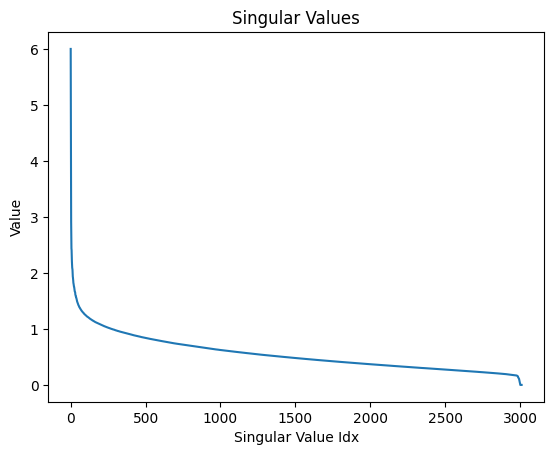

In [28]:
plt.plot(s_values)  # Plot in decreasing order
plt.title('Singular Values')
plt.ylabel('Value')
plt.xlabel('Singular Value Idx')
plt.show()

### (D)

In [54]:
TOP_N=5

for idx in range(20):
  right_vec = VT[idx, :]
  top_idxs = np.argsort(right_vec)[:TOP_N]
  print(f'Top {idx+1} Singular Vector, Top {TOP_N} Words: {vocab[top_idxs]}')
  print("--------")

Top 1 Singular Vector, Top 5 Words: ['graduate' 'father' 'yesterday' 'mrs' 'daughter']
--------
Top 2 Singular Vector, Top 5 Words: ['graduate' 'father' 'mrs' 'bridegroom' 'daughter']
--------
Top 3 Singular Vector, Top 5 Words: ['percent' 'company' 'rate' 'share' 'fund']
--------
Top 4 Singular Vector, Top 5 Words: ['editor' 'police' 'article' 'death' 'child']
--------
Top 5 Singular Vector, Top 5 Words: ['music' 'art' 'artist' 'performance' 'film']
--------
Top 6 Singular Vector, Top 5 Words: ['fund' 'rate' 'percent' 'discount' 'bill']
--------
Top 7 Singular Vector, Top 5 Words: ['police' 'yesterday' 'arrest' 'charge' 'officer']
--------
Top 8 Singular Vector, Top 5 Words: ['fund' 'yesterday' 'music' 'mutual' 'decrease']
--------
Top 9 Singular Vector, Top 5 Words: ['fund' 'garage' 'contract' 'deck' 'mutual']
--------
Top 10 Singular Vector, Top 5 Words: ['editor' 'article' 'contract' 'share' 'net']
--------
Top 11 Singular Vector, Top 5 Words: ['editor' 'article' 'aug' 'feb' 'vice'

Many of the top singular vectors appear to correspond to semantic themes/topics in natural language. Some notable clusters in this dataset include weddings, finances, law enforcement, art, and sports.